# Load in Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve
import matplotlib.colors as col
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter
#from skimage.draw import disk
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
import csv
import xarray as xr
from collections import defaultdict

import sys, os
#sys.path.append(os.path.abspath("R:\Lawson\mpes-analysis"))  # or full path to project
#sys.path.append(os.path.abspath("R:\Lawson\specsanalyzer"))  # or full path to project
sys.path.append(os.path.abspath("/Users/lawsonlloyd/GitHub/mpes-analysis"))  # or full path to project
#sys.path.append(os.path.abspath("/Users/lawsonlloyd/GitHub/specsscan"))  # or full path to project

#from specsanalyzer import SpecsAnalyzer
import mpes
from Loader import DataLoader
from mpes import cmap_LTL, cmap_LTL2
import phoibos

#from specsscan import SpecsScan

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Path and Scan Database Information

In [3]:
#%% Load Data Scan Info

filename = '2024 Bulk CrSBr Phoibos.csv'

scan_info = {}
data_path = 'R:\Lawson\Data\phoibos'
data_path_info = 'R:\Lawson\CrSBr-analysis-manuscript\Analysis Scripts'

data_path = '/Users/lawsonlloyd/Desktop/Data/phoibos'
data_path_info = '/Users/lawsonlloyd/GitHub/CrSBr-analysis-manuscript/Analysis Scripts'

energy_offset, delay_offset, force_offset = 19.62,  0, False

scan_info = phoibos.get_scan_info(data_path_info, filename, {})

In [34]:
scan = 14234

I = phoibos.load_data(data_path, scan, force_offset=False, scan_info = None, energy_offset=20, delay_offset=0, tilt_scan = False) # For .h5 files saved locally
I_res = I/np.max(I)

I.dims

('angle', 'E', 'delay')

In [2]:
specsscan_path = "/Users/lawsonlloyd/GitHub/specsscan/specsscan"

#sps = SpecsScan(config=file.path(specsscan_path, "", "new_config.yaml"))
sps = SpecsScan(config= (str(specsscan_path + "/config/config.yaml")))

scan = 14884

# Load from the Server
I = sps.load_scan(
    scan=scan,
    #path = "//nap32/topfloor/trARPES/PESData/"
)

I_res = I/np.max(I)

NameError: name 'SpecsScan' is not defined

# Plot the Data

#### Tilt Frame

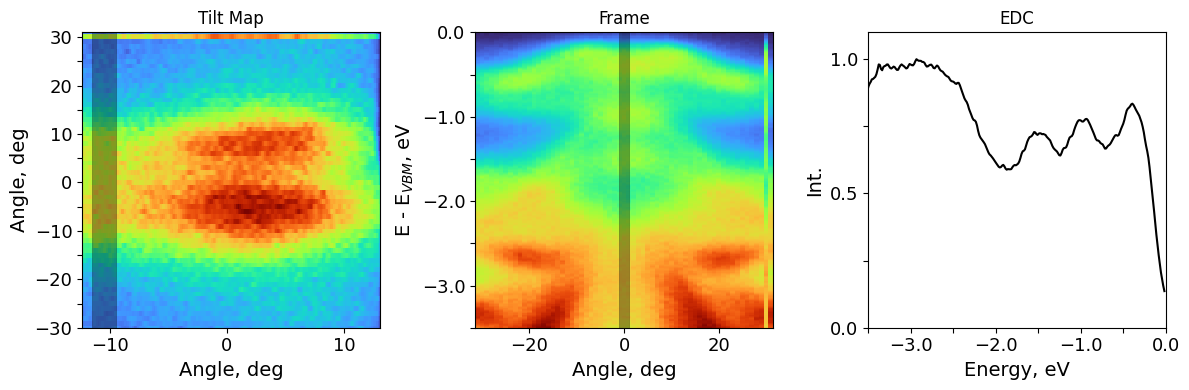

In [169]:
%matplotlib inline

fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios':[1]})
fig.set_size_inches(12, 4, forward=False)
ax = ax.flatten()

E, E_int = 0, 0.2
angle, tilt = -10.5, 0
angle_int, tilt_int = 2, 2

im0 = mpes.plot_tilt_map(I_res, E = E, E_int = E_int, fig=fig, ax=ax[0], subtract_neg = False, cmap='turbo')
im1 = mpes.plot_phoibos_frame(I_res, fig=fig, ax=ax[1], subtract_neg = False, angle = angle, angle_int = angle_int, cmap='turbo')
#im2 = mpes.plot_phoibos_frame(I_res, fig=fig, ax=ax[2], E_enhance = 0.9, subtract_neg = False, tilt = 2, tilt_int = 1)
im2 = mpes.plot_edc(I_res, (angle, tilt), (angle_int, tilt_int), fig=fig, ax=ax[2], subtract_neg = False, norm_trace = True)

ax[1].set_ylim(-3.5,0)
ax[2].set_xlim(-3.5,0)
ax[2].set_title('EDC')
mpes.add_rect(angle, angle_int, 0, 65, ax[0], edgecolor=colors[i], facecolor=colors[i], alpha = 0.35)
mpes.add_rect(tilt, tilt_int, -2, 5, ax[1], edgecolor=colors[i], facecolor=colors[i], alpha = 0.35)

fig.tight_layout()

#### Delay Scan

In [73]:
scan = 13068

I = phoibos.load_data(data_path, scan, force_offset=False, scan_info = None, energy_offset=19.72, delay_offset=0, tilt_scan = False) # For .h5 files saved locally
I_res = I/np.max(I)

I.dims

('angle', 'E', 'delay')

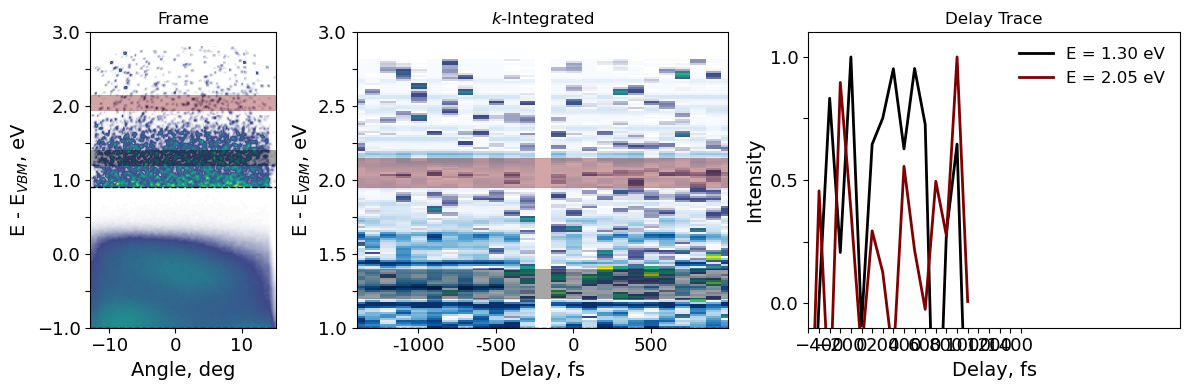

In [74]:
%matplotlib inline

fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 2, 2], 'height_ratios':[1]})
fig.set_size_inches(12, 4, forward=False)
ax = ax.flatten()

im0 = mpes.plot_phoibos_frame(I_res, fig=fig, ax=ax[0], energy_limits=(-1,3), E_enhance = 0.9, subtract_neg = False)
waterfall = mpes.plot_waterfall(I_res, 0, 30, fig = fig, ax=ax[1], subtract_neg=True)

E, E_int = [1.3, 2.05], 0.2
a, a_int = 0, 30
colors = ['black', 'maroon', 'grey']
traces = mpes.get_time_trace(I_res, E[0], E_int, a, a_int)
mpes.plot_time_traces(I_res, E, E_int, a, a_int, fig=fig, ax=ax[2], colors = colors)

for i in np.arange(len(E)):
    mpes.add_rect(a, a_int, E[i], E_int, ax[0], edgecolor=colors[i], facecolor=colors[i], alpha = 0.35)
    mpes.add_rect(500, 50000, E[i], E_int, ax[1], edgecolor=colors[i], facecolor=colors[i], alpha = 0.35)

ax[2].set_xlim(-500, 3000)
#ax[2].set_title(fr"Scan: {scan}. Width = ${popt[1]:.0f}$ fs")
ax[2].set_title('Delay Trace')

fig.tight_layout()


t0 = -12.2 +/- 3.0 fs
width = 81.3 +/- 5.9 fs


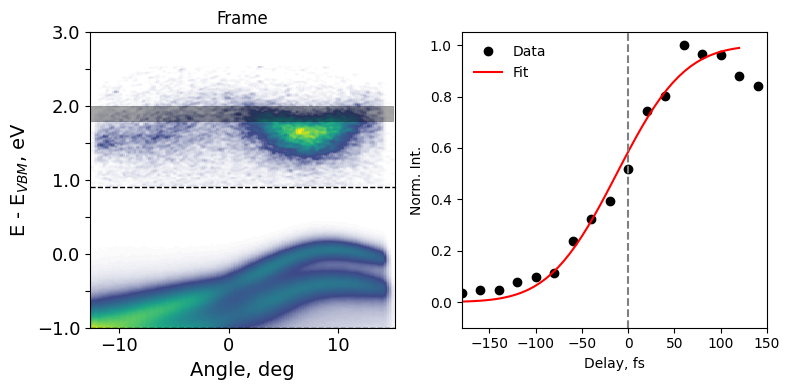

In [29]:
#%% Define t0 from Exciton Rise

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1], 'height_ratios':[1]})
fig.set_size_inches(8, 4, forward=False)
ax = ax.flatten()

figure_file_name = 'define_t0'
save_figure = False

E, E_int = [1.9], 0.2
a, a_int = 0, 30
colors = ['black', 'maroon', 'grey']
traces = mpes.get_time_trace(I_res, E[0], E_int, a, a_int)
#(kx, ky), (kx_int, ky_int) = (0, .7), (1.5, 0.5)
delay_limits = [-200, 120]
im0 = mpes.plot_phoibos_frame(I_res, fig=fig, ax=ax[0], energy_limits=(-1,3), E_enhance = 0.9, subtract_neg = False)

popt, perr, rise_fit = mpes.find_t0(traces/np.max(traces), delay_limits, fig=fig, ax=ax)

for i in np.arange(len(E)):
    mpes.add_rect(a, a_int, E[i], E_int, ax[0], edgecolor=colors[i], facecolor=colors[i], alpha = 0.35)

fig.tight_layout()

if save_figure is True:
    mpes.save_figure(fig, name = f'test', image_format = 'pdf')